In [2]:
import tensorflow as tf
import numpy as np
from scipy.misc import imread
from glob import glob
from matplotlib import pyplot as plt
from os.path import exists
%matplotlib inline

np.random.seed(42)

In [3]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [4]:
def get_name(filepath):
    return filepath.split('/')[-1]

n_cracked   = len(glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png'))
n_query     = 3

cracked_score_fps   = glob('./Data/170729_Panel_Solos_Resized/CrackedScores/*.png')
uncracked_score_fps = glob('./Data/170729_Panel_Solos_Resized/UncrackedScores/*.png') 

image_filepaths     = (['./Data/170729_Panel_Solos_Resized/Cracked/' + get_name(fp) 
                         for fp in cracked_score_fps] +
                       ['./Data/170729_Panel_Solos_Resized/Uncracked/' + get_name(fp)
                         for fp in uncracked_score_fps])

score_filepaths  = ( cracked_score_fps +
                      uncracked_score_fps )

scores  = np.expand_dims(np.array(
                [imread(fp) for fp in score_filepaths], dtype = 'float32'), axis = -1) / 255
scores  = np.concatenate([scores, 1 - scores], axis = -1) # 'One-hot' encode scores
images  = np.expand_dims(np.array(
                [imread(fp) for fp in image_filepaths], dtype = 'float32'), axis = -1)
images  = (images - 128)/128

query_ix     = np.random.randint(0, n_cracked, 3)
query_mask   = np.zeros([scores.shape[0]], dtype = bool)
query_mask[query_ix] = True

query_scores = scores[query_mask, :, :, :]
query_images = images[query_mask, :, :, :]
scores       = scores[np.logical_not(query_mask), :, :, :]
images       = images[np.logical_not(query_mask), :, :, :]

labels       = (np.sum(scores, axis = (1, 2)) > 0).squeeze()[:, 0]

print('Images and score masks successfully read.')

Images and score masks successfully read.


In [177]:
def fft_filter(image, wsize_lower=None, wsize_upper=None):
    """
    wsize_upper denotes the upper boundary on the retained frequencies.
    wsize_lower denotes the lower boundary on the retained frequencies.
    """
    if wsize_upper == 'max': wsize_upper = np.min(image.shape)//2
    fimg = fftshift(fft2(image))
    mask_lower = np.zeros_like(fimg).astype(bool)
    mask_upper = np.zeros_like(fimg).astype(bool)
    mask_lower[ fimg.shape[0]//2 - wsize_lower : fimg.shape[0]//2 + wsize_lower,
                fimg.shape[1]//2 - wsize_lower : fimg.shape[1]//2 + wsize_lower ] = True
    mask_upper[ fimg.shape[0]//2 - wsize_upper : fimg.shape[0]//2 + wsize_upper,
                fimg.shape[1]//2 - wsize_upper : fimg.shape[1]//2 + wsize_upper ] = True
    mask       = np.logical_and(np.logical_not(mask_lower), mask_upper)
    fimg[mask] = 0
    filt_img = np.abs(ifft2(ifftshift(fimg)))
    return filt_img

### Filtering low frequencies

In [299]:
fft_image = images[12, :, :, 0]

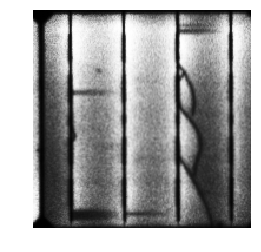

In [301]:
plt.imshow(fft_image, cmap = 'gray')
plt.axis('off');

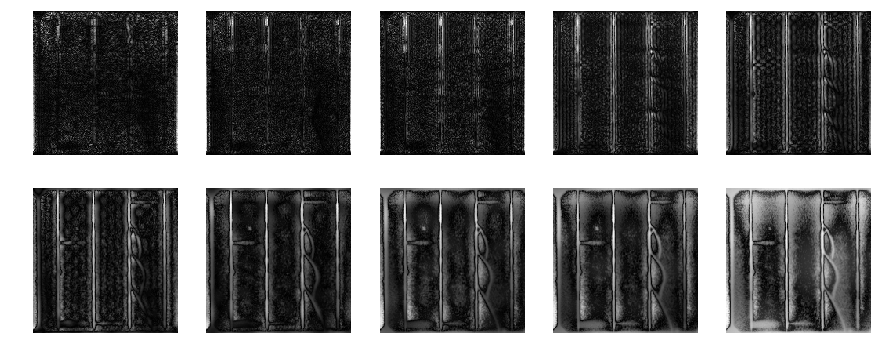

In [302]:
WSIZE = [60, 40, 30, 20, 15, 10, 5, 3, 2, 1]
f, axs = plt.subplots(2, 5, figsize = (15, 6))
for w, ax in zip(WSIZE, axs.flatten()):
    ax.imshow(fft_filter(fft_image, wsize_lower = 0, wsize_upper = w), cmap = 'gray')
    ax.axis('off')

### Filtering high frequencies

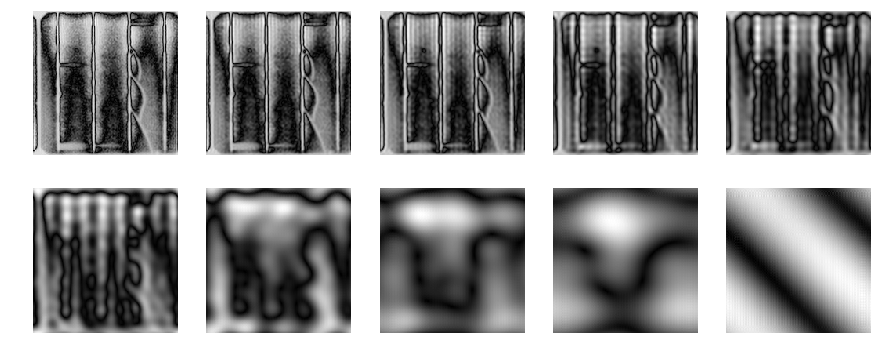

In [303]:
WSIZE = [60, 40, 30, 20, 15, 10, 5, 3, 2, 1]
f, axs = plt.subplots(2, 5, figsize = (15, 6))
for w, ax in zip(WSIZE, axs.flatten()):
    ax.imshow(fft_filter(fft_image, wsize_lower = w, wsize_upper = 'max'), cmap = 'gray')
    ax.axis('off')

### Bandpass filter

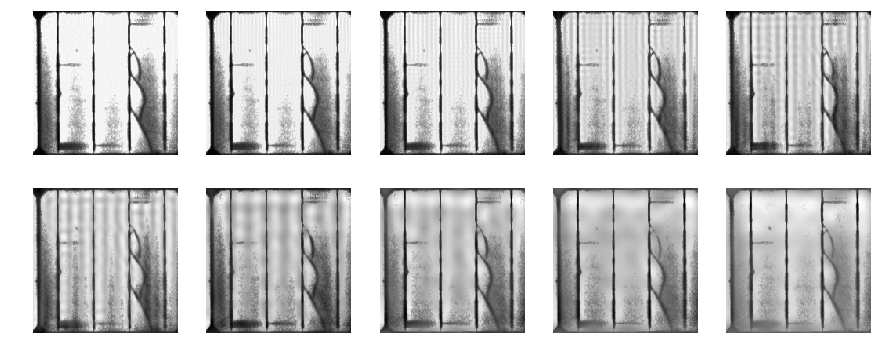

In [304]:
WSIZE = [60, 40, 30, 20, 15, 10, 5, 3, 2, 1]
f, axs = plt.subplots(2, 5, figsize = (15, 6))
for w, ax in zip(WSIZE, axs.flatten()):
    ax.imshow(fft_image - fft_filter(fft_image, wsize_lower = w, wsize_upper = w + 5), cmap = 'gray')
    ax.axis('off')

Interesting...

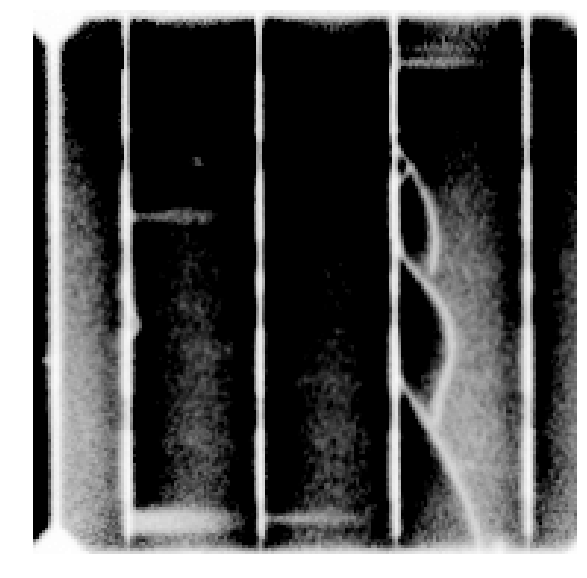

In [305]:
plt.figure(figsize = (10, 10))
plt.imshow(fft_filter(fft_image, wsize_lower = 92, wsize_upper = 'max') - fft_image, cmap = 'gray')
plt.axis('off');

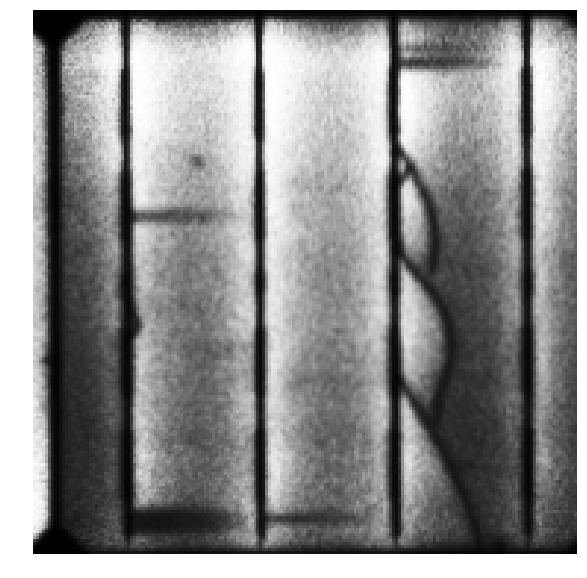

In [306]:
plt.figure(figsize = (10, 10))
plt.imshow(fft_image, cmap = 'gray')
plt.axis('off');